# Prepare Data

In [2]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
import skimage
from PIL import Image
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.util import crop, pad
from skimage.morphology import label
from skimage.color import rgb2gray, gray2rgb, rgb2lab, lab2rgb
from sklearn.model_selection import train_test_split

from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.models import Model, load_model,Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, UpSampling2D, RepeatVector, Reshape
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

import tensorflow as tf

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

Get Data

In [3]:
!pip install opendatasets --upgrade --quiet

In [4]:
import opendatasets as od
dataset_url = 'https://www.kaggle.com/mbachvarova/artimagesdrawingspaintingsculptureengraving'
od.download(dataset_url)

100%|██████████| 1.14G/1.14G [00:08<00:00, 142MB/s]


In [5]:
# Parameters
training_dataset_path = "/content/artimagesdrawingspaintingsculptureengraving/dataset/dataset_updated/training_set"
test_dataset_path = "/content/artimagesdrawingspaintingsculptureengraving/dataset/dataset_updated/validation_set"

# categories to use
# categories = ['drawings', 'engraving', 'iconography', 'painting']
categories = ['drawings', 'engraving', 'iconography', 'painting', 'sculpture']
n_categories = len(categories)
category_embeddings = {
    'drawings': 0,
    'engraving': 1,
    'iconography': 2,
    'painting': 3,
    'sculpture': 4
}

In [6]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
INPUT_SHAPE=(IMG_HEIGHT, IMG_WIDTH, 1)
TRAIN_PATH = '/content/artimagesdrawingspaintingsculptureengraving/dataset/dataset_updated/training_set/painting/'

train_ids = next(os.walk(TRAIN_PATH))[2]

In [7]:
%%time
X_train = np.zeros((len(train_ids)-86, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
missing_count = 0
print('Getting train images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_+''
    try:
        img = imread(path)
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_train[n-missing_count] = img
    except:
#         print(" Problem with: "+path)
        missing_count += 1

X_train = X_train.astype('float32') / 255.
print("Total missing: "+ str(missing_count))

Getting train images ... 


100%|██████████| 2128/2128 [00:37<00:00, 56.02it/s]


Total missing: 86
CPU times: user 34.7 s, sys: 28.5 s, total: 1min 3s
Wall time: 38.7 s


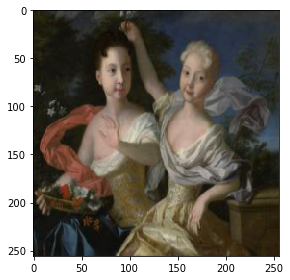

In [ ]:
imshow(X_train[5])
plt.show()

### Train/Test Split
Just getting a sample of 20 images to test the model when it is done.

In [8]:
X_train, X_test = train_test_split(X_train, test_size=20, random_state=seed)

In [ ]:
print(X_train.shape)
print(X_test.shape)

(2022, 256, 256, 3)
(20, 256, 256, 3)


# Denoise using Vanilla Autoencoders

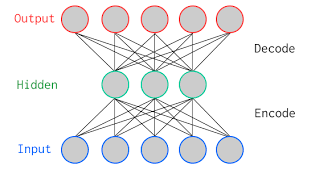

In [9]:
x_train = rgb2gray(X_train)
x_test = rgb2gray(X_test)

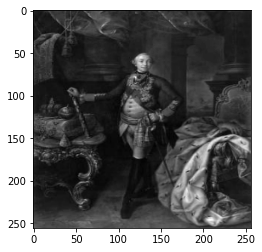

In [10]:
plt.imshow(x_train[1])
plt.gray()

In [11]:
#Requires Libraries
from keras.models import Model
from keras.layers import Dense, Input
from keras import optimizers
import numpy as np

In [12]:
#Reshape
x_train = x_train.reshape((len(x_train),np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test),np.prod(x_test.shape[1:])))
print(x_test.shape)

(20, 65536)


In [13]:
#Add noise to the original image
Corruption_level=0.4 #Corrupting input data to 40%.
x_train_noisy = x_train + Corruption_level*np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) #Add random
x_test_noisy = x_test + Corruption_level*np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
#Clipping
x_train_noisy = np.clip(x_train_noisy, 0., 1.) 
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [14]:
#Model 1 : Vanilla Autoencoder - Adam optimizer and Binary Crossentropy as loss parameter
input_image = Input(shape=(65536,)) #Input layer
encoded = Dense(200,activation='relu')(input_image) #Hidden layer - Bottle neck layer
decoded = Dense(65536, activation='sigmoid')(encoded) #Output layer
noisy_ae1= Model(input_image, decoded)
noisy_ae1.compile(optimizer='adam', loss='binary_crossentropy')
noisy_ae1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 65536)]           0         
                                                                 
 dense (Dense)               (None, 200)               13107400  
                                                                 
 dense_1 (Dense)             (None, 65536)             13172736  
                                                                 
Total params: 26,280,136
Trainable params: 26,280,136
Non-trainable params: 0
_________________________________________________________________


In [15]:
noisy_ae1.fit(x_train_noisy, x_train, epochs=20, batch_size=128, shuffle=True, verbose=1, validation_data=(x_test_noisy, x_test))
decoded_noisy_images1 = noisy_ae1.predict(x_test)

Epoch 1/20
16/16 [==============================] - 4s 60ms/step - loss: 0.6354 - val_loss: 0.6105
Epoch 2/20
16/16 [==============================] - 1s 48ms/step - loss: 0.5990 - val_loss: 0.5917
Epoch 3/20
16/16 [==============================] - 1s 47ms/step - loss: 0.5806 - val_loss: 0.5840
Epoch 4/20
16/16 [==============================] - 1s 47ms/step - loss: 0.5611 - val_loss: 0.5780
Epoch 5/20
16/16 [==============================] - 1s 47ms/step - loss: 0.5512 - val_loss: 0.5710
Epoch 6/20
16/16 [==============================] - 1s 47ms/step - loss: 0.5406 - val_loss: 0.5699
Epoch 7/20
16/16 [==============================] - 1s 47ms/step - loss: 0.5319 - val_loss: 0.5572
Epoch 8/20
16/16 [==============================] - 1s 47ms/step - loss: 0.5328 - val_loss: 0.5585
Epoch 9/20
16/16 [==============================] - 1s 48ms/step - loss: 0.5260 - val_loss: 0.5585
Epoch 10/20
16/16 [==============================] - 1s 48ms/step - loss: 0.5221 - val_loss: 0.5530
Epoch 11/

In [16]:
#Model 2 : Vanilla Autoencoder - optimizer='sgd' and callback=[early_stop]
input_image = Input(shape=(65536,)) #Input layer
encoded = Dense(200,activation='relu')(input_image) #Hidden layer - Bottle neck layer
decoded = Dense(65536, activation='sigmoid')(encoded) #Output layer
noisy_ae2= Model(input_image, decoded)
noisy_ae2.compile(optimizer='sgd', loss=['binary_crossentropy'])
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
#rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_delta=1E-7, verbose=1)
noisy_ae2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 65536)]           0         
                                                                 
 dense_2 (Dense)             (None, 200)               13107400  
                                                                 
 dense_3 (Dense)             (None, 65536)             13172736  
                                                                 
Total params: 26,280,136
Trainable params: 26,280,136
Non-trainable params: 0
_________________________________________________________________


In [17]:
noisy_ae2.fit(x_train_noisy, x_train, epochs=20, batch_size=128, callbacks=[es],shuffle=True, verbose=1, validation_data=(x_test_noisy, x_test))
decoded_noisy_images2 = noisy_ae2.predict(x_test)

Epoch 1/20
16/16 [==============================] - 2s 66ms/step - loss: 0.6933 - val_loss: 0.6933
Epoch 2/20
16/16 [==============================] - 1s 51ms/step - loss: 0.6933 - val_loss: 0.6933
Epoch 3/20
16/16 [==============================] - 1s 47ms/step - loss: 0.6933 - val_loss: 0.6933
Epoch 4/20
16/16 [==============================] - 1s 46ms/step - loss: 0.6933 - val_loss: 0.6933
Epoch 5/20
16/16 [==============================] - 1s 46ms/step - loss: 0.6933 - val_loss: 0.6933
Epoch 6/20
16/16 [==============================] - 1s 46ms/step - loss: 0.6933 - val_loss: 0.6933
Epoch 7/20
16/16 [==============================] - 1s 45ms/step - loss: 0.6933 - val_loss: 0.6933
Epoch 8/20
16/16 [==============================] - 1s 45ms/step - loss: 0.6933 - val_loss: 0.6933
Epoch 9/20
16/16 [==============================] - 1s 46ms/step - loss: 0.6932 - val_loss: 0.6933
Epoch 10/20
16/16 [==============================] - 1s 46ms/step - loss: 0.6932 - val_loss: 0.6933
Epoch 11/

In [18]:
#Model 3 : Vanilla Autoencoder - optimizer='adam', loss='binary_crossentropy', callbacks=[early_stop]
input_image = Input(shape=(65536,)) #Input layer
encoded = Dense(200,activation='relu')(input_image) #Hidden layer - Bottle neck layer
decoded = Dense(65536, activation='sigmoid')(encoded) #Output layer
noisy_ae3= Model(input_image, decoded)
noisy_ae3.compile(optimizer='adam', loss='binary_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
noisy_ae3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 65536)]           0         
                                                                 
 dense_4 (Dense)             (None, 200)               13107400  
                                                                 
 dense_5 (Dense)             (None, 65536)             13172736  
                                                                 
Total params: 26,280,136
Trainable params: 26,280,136
Non-trainable params: 0
_________________________________________________________________


In [38]:
#Model 3 : Vanilla Autoencoder - optimizer='adam', loss='binary_crossentropy', callbacks=[early_stop]
input_image = Input(shape=(65536,)) #Input layer
encoded = Dense(200,activation='relu')(input_image) #Hidden layer - Bottle neck layer
decoded = Dense(65536, activation='sigmoid')(encoded) #Output layer
noisy_ae3= Model(input_image, decoded)
noisy_ae3.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['MeanSquaredError','AUC'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
noisy_ae3.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 65536)]           0         
                                                                 
 dense_26 (Dense)            (None, 200)               13107400  
                                                                 
 dense_27 (Dense)            (None, 65536)             13172736  
                                                                 
Total params: 26,280,136
Trainable params: 26,280,136
Non-trainable params: 0
_________________________________________________________________


In [39]:
noisy_ae3.fit(x_train_noisy, x_train, epochs=20, batch_size=128, callbacks=[es],shuffle=True, verbose=1, validation_data=(x_test_noisy, x_test))
decoded_noisy_images3 = noisy_ae3.predict(x_test)

Epoch 1/20
16/16 [==============================] - 2s 81ms/step - loss: 0.6389 - mean_squared_error: 0.0624 - auc: 0.5658 - val_loss: 0.6047 - val_mean_squared_error: 0.0472 - val_auc: 0.0000e+00
Epoch 2/20
16/16 [==============================] - 1s 58ms/step - loss: 0.5981 - mean_squared_error: 0.0446 - auc: 0.7760 - val_loss: 0.5985 - val_mean_squared_error: 0.0437 - val_auc: 0.0000e+00
Epoch 3/20
16/16 [==============================] - 1s 59ms/step - loss: 0.5775 - mean_squared_error: 0.0362 - auc: 0.7676 - val_loss: 0.5868 - val_mean_squared_error: 0.0394 - val_auc: 0.0000e+00
Epoch 4/20
16/16 [==============================] - 1s 58ms/step - loss: 0.5591 - mean_squared_error: 0.0286 - auc: 0.7907 - val_loss: 0.5710 - val_mean_squared_error: 0.0327 - val_auc: 0.0000e+00
Epoch 5/20
16/16 [==============================] - 1s 59ms/step - loss: 0.5510 - mean_squared_error: 0.0252 - auc: 0.8104 - val_loss: 0.5837 - val_mean_squared_error: 0.0370 - val_auc: 0.0000e+00
Epoch 6/20
16/1

In [20]:
#Model 4 : Vanilla Autoencoder - optimizer='adam', loss='mse', callbacks=[early_stop]
input_image = Input(shape=(65536,)) #Input layer
encoded = Dense(200,activation='relu')(input_image) #Hidden layer - Bottle neck layer
decoded = Dense(65536, activation='sigmoid')(encoded) #Output layer
noisy_ae4= Model(input_image, decoded)
noisy_ae4.compile(optimizer='adam', loss='mse')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
noisy_ae4.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 65536)]           0         
                                                                 
 dense_6 (Dense)             (None, 200)               13107400  
                                                                 
 dense_7 (Dense)             (None, 65536)             13172736  
                                                                 
Total params: 26,280,136
Trainable params: 26,280,136
Non-trainable params: 0
_________________________________________________________________


In [21]:
noisy_ae4.fit(x_train_noisy, x_train, epochs=20, batch_size=128, callbacks=[es],shuffle=True, verbose=1, validation_data=(x_test_noisy, x_test))
decoded_noisy_images4 = noisy_ae4.predict(x_test)

Epoch 1/20
16/16 [==============================] - 1s 53ms/step - loss: 0.0641 - val_loss: 0.0498
Epoch 2/20
16/16 [==============================] - 1s 44ms/step - loss: 0.0461 - val_loss: 0.0450
Epoch 3/20
16/16 [==============================] - 1s 43ms/step - loss: 0.0373 - val_loss: 0.0359
Epoch 4/20
16/16 [==============================] - 1s 44ms/step - loss: 0.0299 - val_loss: 0.0352
Epoch 5/20
16/16 [==============================] - 1s 44ms/step - loss: 0.0286 - val_loss: 0.0324
Epoch 6/20
16/16 [==============================] - 1s 44ms/step - loss: 0.0229 - val_loss: 0.0310
Epoch 7/20
16/16 [==============================] - 1s 42ms/step - loss: 0.0194 - val_loss: 0.0289
Epoch 8/20
16/16 [==============================] - 1s 42ms/step - loss: 0.0167 - val_loss: 0.0269
Epoch 9/20
16/16 [==============================] - 1s 43ms/step - loss: 0.0150 - val_loss: 0.0283
Epoch 10/20
16/16 [==============================] - 1s 43ms/step - loss: 0.0138 - val_loss: 0.0265
Epoch 11/

In [22]:
def plotImages(image_data, n, title=""):
  plt.figure(figsize=(15,3))
  for i in range(n):
        ax = plt.subplot(1,n,i+1)
        plt.imshow(image_data[i].reshape(256,256)) #reshape and show because we have flattened the image.
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
  plt.suptitle(title, fontsize = 20)

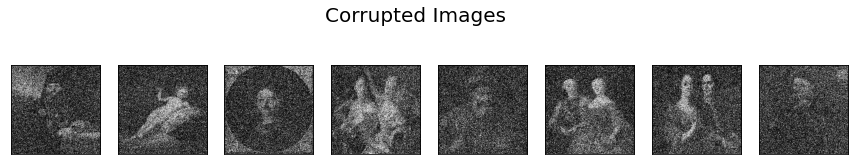

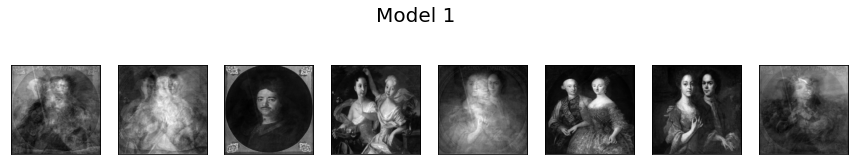

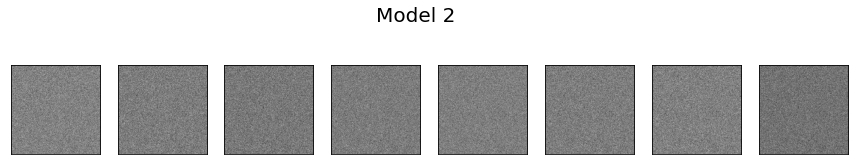

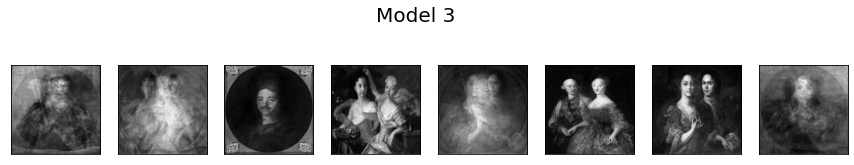

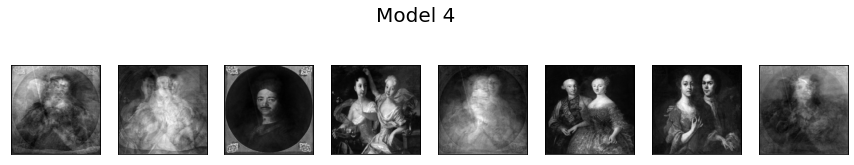

In [23]:
plotImages(x_test_noisy, 8, "Corrupted Images")
plotImages(decoded_noisy_images1, 8, "Model 1")
plotImages(decoded_noisy_images2, 8, "Model 2")
plotImages(decoded_noisy_images3, 8, "Model 3")
plotImages(decoded_noisy_images4, 8, "Model 4")

# Denoise using Deep Autoencoders

In [24]:
#Model 5 : Deep Autoencoders using 'adadelta' optimizer and 'binary_crossentropy' as loss parameter
input_image = Input(shape=(65536,)) #Input layer
encoded = Dense(1000,activation='relu')(input_image) 
encoded = Dense(500,activation='relu')(input_image) 
encoded = Dense(250,activation='relu')(input_image) 
encoded = Dense(100,activation='relu')(encoded) #Bottle-neck layer
encoded = Dense(250,activation='relu')(encoded) 
encoded = Dense(500,activation='relu')(input_image) 
encoded = Dense(1000,activation='relu')(input_image) 
decoded = Dense(65536, activation='sigmoid')(encoded) #Output layer
noisy_ae5 = Model(input_image, decoded)
noisy_ae5.compile(optimizer='adadelta', loss='binary_crossentropy')
noisy_ae5.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 65536)]           0         
                                                                 
 dense_14 (Dense)            (None, 1000)              65537000  
                                                                 
 dense_15 (Dense)            (None, 65536)             65601536  
                                                                 
Total params: 131,138,536
Trainable params: 131,138,536
Non-trainable params: 0
_________________________________________________________________


In [25]:
noisy_ae5.fit(x_train_noisy, x_train, epochs=20, batch_size=128, shuffle=True, verbose=1, validation_data=(x_test_noisy, x_test))
decoded_noisy_images5 = noisy_ae5.predict(x_test)

Epoch 1/20
16/16 [==============================] - 2s 101ms/step - loss: 0.6941 - val_loss: 0.6941
Epoch 2/20
16/16 [==============================] - 1s 85ms/step - loss: 0.6941 - val_loss: 0.6941
Epoch 3/20
16/16 [==============================] - 1s 84ms/step - loss: 0.6941 - val_loss: 0.6941
Epoch 4/20
16/16 [==============================] - 1s 82ms/step - loss: 0.6941 - val_loss: 0.6941
Epoch 5/20
16/16 [==============================] - 1s 85ms/step - loss: 0.6941 - val_loss: 0.6941
Epoch 6/20
16/16 [==============================] - 1s 83ms/step - loss: 0.6941 - val_loss: 0.6941
Epoch 7/20
16/16 [==============================] - 1s 83ms/step - loss: 0.6941 - val_loss: 0.6941
Epoch 8/20
16/16 [==============================] - 1s 85ms/step - loss: 0.6941 - val_loss: 0.6941
Epoch 9/20
16/16 [==============================] - 1s 82ms/step - loss: 0.6941 - val_loss: 0.6941
Epoch 10/20
16/16 [==============================] - 1s 84ms/step - loss: 0.6941 - val_loss: 0.6941
Epoch 11

In [26]:
#Model 6 - Deep Autoencoders : Adam optimizer and Mean Squared Error
input_image = Input(shape=(65536,)) #Input layer
encoded = Dense(1000,activation='relu')(input_image) 
encoded = Dense(500,activation='relu')(input_image) 
encoded = Dense(250,activation='relu')(input_image) 
encoded = Dense(100,activation='relu')(encoded) #Bottle-neck layer
encoded = Dense(250,activation='relu')(encoded) 
encoded = Dense(500,activation='relu')(input_image) 
encoded = Dense(1000,activation='relu')(input_image) 
decoded = Dense(65536, activation='sigmoid')(encoded) #Output layer
noisy_ae6 = Model(input_image, decoded)
noisy_ae6.compile(optimizer='adam', loss='mse')
noisy_ae2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 65536)]           0         
                                                                 
 dense_2 (Dense)             (None, 200)               13107400  
                                                                 
 dense_3 (Dense)             (None, 65536)             13172736  
                                                                 
Total params: 26,280,136
Trainable params: 26,280,136
Non-trainable params: 0
_________________________________________________________________


In [27]:
noisy_ae6.fit(x_train_noisy, x_train, epochs=20, batch_size=128, shuffle=True, verbose=1, validation_data=(x_test_noisy, x_test))
decoded_noisy_images6 = noisy_ae6.predict(x_test)

Epoch 1/20
16/16 [==============================] - 2s 81ms/step - loss: 0.0631 - val_loss: 0.0456
Epoch 2/20
16/16 [==============================] - 1s 72ms/step - loss: 0.0425 - val_loss: 0.0392
Epoch 3/20
16/16 [==============================] - 1s 72ms/step - loss: 0.0321 - val_loss: 0.0323
Epoch 4/20
16/16 [==============================] - 1s 73ms/step - loss: 0.0243 - val_loss: 0.0297
Epoch 5/20
16/16 [==============================] - 1s 71ms/step - loss: 0.0222 - val_loss: 0.0320
Epoch 6/20
16/16 [==============================] - 1s 72ms/step - loss: 0.0199 - val_loss: 0.0273
Epoch 7/20
16/16 [==============================] - 1s 73ms/step - loss: 0.0169 - val_loss: 0.0250
Epoch 8/20
16/16 [==============================] - 1s 70ms/step - loss: 0.0136 - val_loss: 0.0255
Epoch 9/20
16/16 [==============================] - 1s 72ms/step - loss: 0.0119 - val_loss: 0.0232
Epoch 10/20
16/16 [==============================] - 1s 71ms/step - loss: 0.0108 - val_loss: 0.0220
Epoch 11/

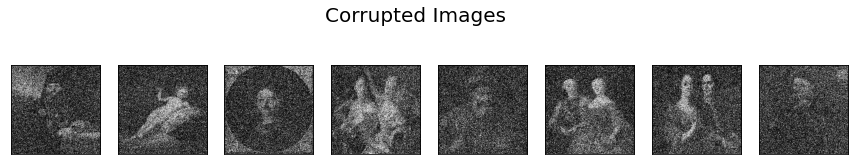

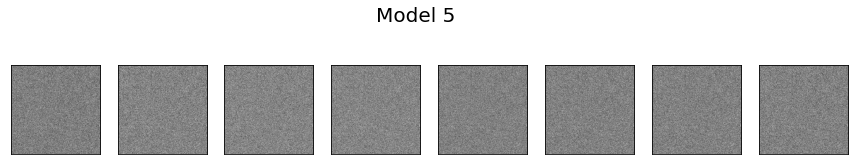

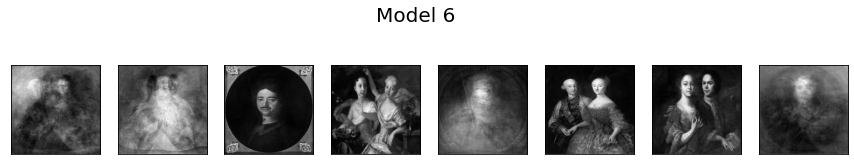

In [28]:
plotImages(x_test_noisy, 8, "Corrupted Images")
plotImages(decoded_noisy_images5, 8, "Model 5")
plotImages(decoded_noisy_images6, 8, "Model 6")

### Evaluation

In [31]:
# def plotEvaluation(model, title=""):
#   plt.figure(figsize=(15,3))
#   ax = plt.subplot(1,1,1)
#   loss = model.history['loss']
#   val_loss = model.history['val_loss']
#   epochs = range(20)
#   plt.plot(epochs, loss, 'bo', label='Training loss')
#   plt.plot(epochs, val_loss, 'b', label='Validation loss')
#   plt.title('Training and validation loss')
#   plt.legend()
#   plt.show()
#   ax.get_xaxis().set_visible(False)
#   ax.get_yaxis().set_visible(False)
#   plt.suptitle(title, fontsize = 20)

In [51]:
# loss = noisy_ae3.history.history['mean_squared_error']
# val_loss = noisy_ae3.history['val_loss']
# epochs = range(20)
# plt.figure()
# plt.plot(epochs, loss, 'bo', label='Training loss')
# plt.plot(epochs, val_loss, 'b', label='Validation loss')
# plt.title('Training and validation loss')
# plt.legend()
# plt.show()


In [50]:
# plotEvaluation(noisy_ae2, "Model 2")
# plotEvaluation(noisy_ae3, "Model 3")
# plotEvaluation(noisy_ae8, "Model 8")

In [55]:
import math
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0): 
        return 100
    max_pixel = 255.0
    x= np.log(max_pixel / math.sqrt(mse))
    psnr = 20 * x
    return psnr

In [59]:
print("PSNR Comparison")
print("Model 1 : ",PSNR(x_test[1], decoded_noisy_images1[1]))
print("Model 2 : ",PSNR(x_test[1], decoded_noisy_images2[1]))
print("Model 3 : ",PSNR(x_test[1], decoded_noisy_images3[1]))
print("Model 4 : ",PSNR(x_test[1], decoded_noisy_images4[1]))
print("Model 5 : ",PSNR(x_test[1], decoded_noisy_images5[1]))
print("Model 6 : ",PSNR(x_test[1], decoded_noisy_images6[1]))

PSNR Comparison
Model 1 :  139.8235244060101
Model 2 :  132.15353864355654
Model 3 :  140.5374529912178
Model 4 :  139.69293752497552
Model 5 :  132.13756779904028
Model 6 :  139.29347898452517


In [49]:
noisy_ae3.evaluate(x_train_noisy, x_train)

64/64 [==============================] - 1s 14ms/step - loss: 0.5160 - mean_squared_error: 0.0110 - auc: 0.8985


[0.5160062909126282, 0.011028187349438667, 0.898460865020752]

# Reconstruct using Vanilla Autoencoders

Models :
1. ae7 using 'binary_crossentroy' as loss prameter
2. ae8 using 'mse' as loss parameter

In [60]:
#Model 7 : Vanilla Autoencoder
input_image = Input(shape=(65536,)) #Input layer
encoded = Dense(200,activation='relu')(input_image) #Hidden layer - Bottle neck layer
decoded = Dense(65536, activation='sigmoid')(encoded) #Output layer
ae7= Model(input_image, decoded)
ae7.compile(optimizer='adam', loss='binary_crossentropy')
ae7.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 65536)]           0         
                                                                 
 dense_28 (Dense)            (None, 200)               13107400  
                                                                 
 dense_29 (Dense)            (None, 65536)             13172736  
                                                                 
Total params: 26,280,136
Trainable params: 26,280,136
Non-trainable params: 0
_________________________________________________________________


In [61]:
ae7.fit(x_train, x_train, epochs=5, batch_size=128, shuffle=True, verbose=1, validation_data=(x_test, x_test))

Epoch 1/5
16/16 [==============================] - 1s 69ms/step - loss: 0.6413 - val_loss: 0.6096
Epoch 2/5
16/16 [==============================] - 1s 58ms/step - loss: 0.5893 - val_loss: 0.5819
Epoch 3/5
16/16 [==============================] - 1s 77ms/step - loss: 0.5623 - val_loss: 0.5636
Epoch 4/5
16/16 [==============================] - 1s 50ms/step - loss: 0.5508 - val_loss: 0.5567
Epoch 5/5
16/16 [==============================] - 1s 47ms/step - loss: 0.5442 - val_loss: 0.5481


In [62]:
decoded_images7 = ae7.predict(x_test)

To decrease loss

In [63]:
#Model 8 - Vanilla Autoencoder
input_image = Input(shape=(65536,)) #Input layer
encoded = Dense(200,activation='relu')(input_image) #Hidden layer - Bottle neck layer
decoded = Dense(65536, activation='sigmoid')(encoded) #Output layer
ae8= Model(input_image, decoded)
ae8.compile(optimizer='adam', loss='mse')
ae8.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 65536)]           0         
                                                                 
 dense_30 (Dense)            (None, 200)               13107400  
                                                                 
 dense_31 (Dense)            (None, 65536)             13172736  
                                                                 
Total params: 26,280,136
Trainable params: 26,280,136
Non-trainable params: 0
_________________________________________________________________


In [64]:
ae8.fit(x_train, x_train, epochs=5, batch_size=128, shuffle=True, verbose=1, validation_data=(x_test, x_test))

Epoch 1/5
16/16 [==============================] - 1s 53ms/step - loss: 0.0631 - val_loss: 0.0432
Epoch 2/5
16/16 [==============================] - 1s 46ms/step - loss: 0.0374 - val_loss: 0.0350
Epoch 3/5
16/16 [==============================] - 1s 44ms/step - loss: 0.0276 - val_loss: 0.0283
Epoch 4/5
16/16 [==============================] - 1s 45ms/step - loss: 0.0227 - val_loss: 0.0230
Epoch 5/5
16/16 [==============================] - 1s 42ms/step - loss: 0.0206 - val_loss: 0.0215


In [65]:
decoded_images8 = ae8.predict(x_test)

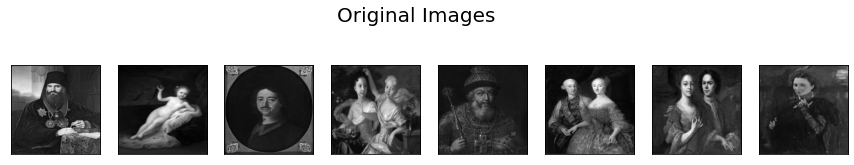

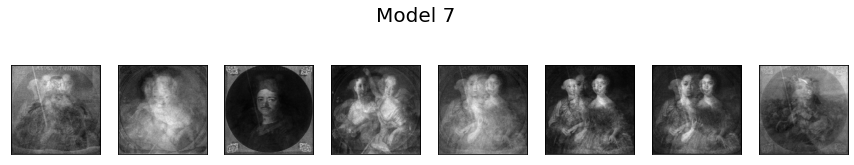

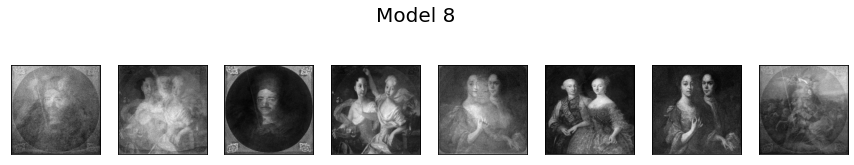

In [67]:
plotImages(x_test, 8, "Original Images")
plotImages(decoded_images7, 8, "Model 7")
plotImages(decoded_images8, 8, "Model 8")

# Reconstruct using Sparce Autoencoder
Models :
1. 'sparce_ae' using 'binary_crossentroy' as loss prameter
2. 'sparce_ae2' using 'mse' as loss parameter

In [68]:
#Model 9 : Vanilla Autoencoder
from keras import regularizers
input_image = Input(shape=(65536,)) #Input layer
encoded = Dense(750,activation='relu', activity_regularizer=regularizers.l1(10e-5))(input_image) #Hidden layer - Bottle neck layer
decoded = Dense(65536, activation='sigmoid')(encoded) #Output layer
sparce_ae9 = Model(input_image, decoded)
sparce_ae9.compile(optimizer='adam', loss='binary_crossentropy')
sparce_ae9.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 65536)]           0         
                                                                 
 dense_32 (Dense)            (None, 750)               49152750  
                                                                 
 dense_33 (Dense)            (None, 65536)             49217536  
                                                                 
Total params: 98,370,286
Trainable params: 98,370,286
Non-trainable params: 0
_________________________________________________________________


In [69]:
sparce_ae9.fit(x_train, x_train, epochs=20, batch_size=128, shuffle=True, verbose=1, validation_data=(x_test, x_test))
decoded_sparce_images9 = sparce_ae9.predict(x_test)

Epoch 1/20
16/16 [==============================] - 2s 80ms/step - loss: 0.6930 - val_loss: 0.6906
Epoch 2/20
16/16 [==============================] - 1s 74ms/step - loss: 0.6894 - val_loss: 0.6878
Epoch 3/20
16/16 [==============================] - 1s 71ms/step - loss: 0.6866 - val_loss: 0.6849
Epoch 4/20
16/16 [==============================] - 1s 70ms/step - loss: 0.6837 - val_loss: 0.6820
Epoch 5/20
16/16 [==============================] - 1s 70ms/step - loss: 0.6809 - val_loss: 0.6791
Epoch 6/20
16/16 [==============================] - 1s 69ms/step - loss: 0.6781 - val_loss: 0.6763
Epoch 7/20
16/16 [==============================] - 1s 70ms/step - loss: 0.6754 - val_loss: 0.6736
Epoch 8/20
16/16 [==============================] - 1s 70ms/step - loss: 0.6727 - val_loss: 0.6709
Epoch 9/20
16/16 [==============================] - 1s 70ms/step - loss: 0.6701 - val_loss: 0.6683
Epoch 10/20
16/16 [==============================] - 1s 71ms/step - loss: 0.6676 - val_loss: 0.6657
Epoch 11/

In [70]:
#Model 10 : Vanilla Autoencoder
from keras import regularizers
input_image = Input(shape=(65536,)) #Input layer
encoded = Dense(750,activation='relu', activity_regularizer=regularizers.l1(10e-5))(input_image) #Hidden layer - Bottle neck layer
decoded = Dense(65536, activation='sigmoid')(encoded) #Output layer
sparce_ae10 = Model(input_image, decoded)
sparce_ae10.compile(optimizer='adam', loss='mse')
sparce_ae10.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 65536)]           0         
                                                                 
 dense_34 (Dense)            (None, 750)               49152750  
                                                                 
 dense_35 (Dense)            (None, 65536)             49217536  
                                                                 
Total params: 98,370,286
Trainable params: 98,370,286
Non-trainable params: 0
_________________________________________________________________


In [74]:
sparce_ae10.fit(x_train, x_train, epochs=20, batch_size=128, shuffle=True, verbose=1, validation_data=(x_test, x_test))
decoded_sparce_images10 = sparce_ae10.predict(x_test)

Epoch 1/20
16/16 [==============================] - 1s 69ms/step - loss: 0.0634 - val_loss: 0.0616
Epoch 2/20
16/16 [==============================] - 1s 65ms/step - loss: 0.0627 - val_loss: 0.0609
Epoch 3/20
16/16 [==============================] - 1s 65ms/step - loss: 0.0619 - val_loss: 0.0601
Epoch 4/20
16/16 [==============================] - 1s 64ms/step - loss: 0.0612 - val_loss: 0.0594
Epoch 5/20
16/16 [==============================] - 1s 65ms/step - loss: 0.0605 - val_loss: 0.0587
Epoch 6/20
16/16 [==============================] - 1s 65ms/step - loss: 0.0598 - val_loss: 0.0580
Epoch 7/20
16/16 [==============================] - 1s 64ms/step - loss: 0.0592 - val_loss: 0.0574
Epoch 8/20
16/16 [==============================] - 1s 65ms/step - loss: 0.0586 - val_loss: 0.0567
Epoch 9/20
16/16 [==============================] - 1s 66ms/step - loss: 0.0580 - val_loss: 0.0561
Epoch 10/20
16/16 [==============================] - 1s 65ms/step - loss: 0.0574 - val_loss: 0.0555
Epoch 11/

In [81]:
# #Model 11
# sparce_ae10.fit(x_train, x_train, epochs=5, batch_size=128, shuffle=True, verbose=1, validation_data=(x_test, x_test))
# decoded_sparce_images11 = sparce_ae10.predict(x_test)

Epoch 1/5
16/16 [==============================] - 1s 75ms/step - loss: 0.0433 - val_loss: 0.0412
Epoch 2/5
16/16 [==============================] - 1s 65ms/step - loss: 0.0432 - val_loss: 0.0412
Epoch 3/5
16/16 [==============================] - 1s 64ms/step - loss: 0.0432 - val_loss: 0.0411
Epoch 4/5
16/16 [==============================] - 1s 65ms/step - loss: 0.0431 - val_loss: 0.0411
Epoch 5/5
16/16 [==============================] - 1s 63ms/step - loss: 0.0431 - val_loss: 0.0410


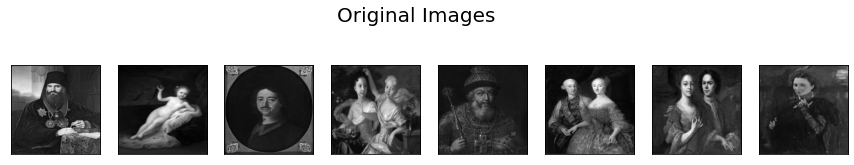

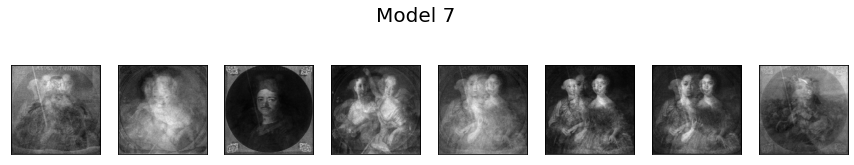

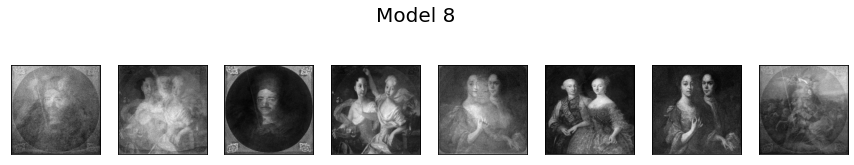

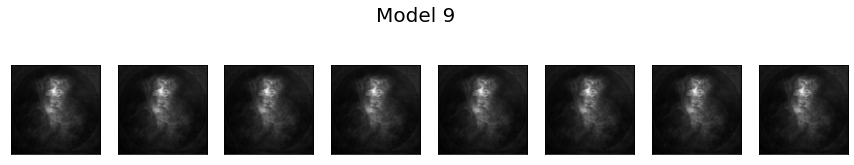

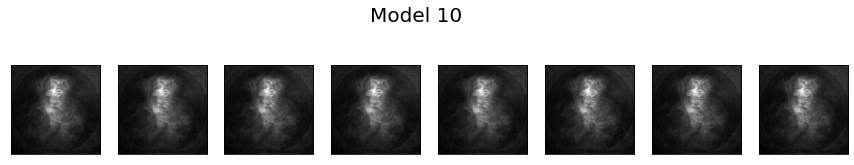

In [85]:
plotImages(x_test, 8, "Original Images")
plotImages(decoded_images7, 8, "Model 7")
plotImages(decoded_images8, 8, "Model 8")
plotImages(decoded_sparce_images9, 8, "Model 9")
plotImages(decoded_sparce_images10, 8, "Model 10")

In [84]:
print("PSNR Comparison")
print("Model 7  : ",PSNR(x_test[1], decoded_images7[1]))
print("Model 8  : ",PSNR(x_test[1], decoded_images8[1]))
print("Model 9  : ",PSNR(x_test[1], decoded_sparce_images9[1]))
print("Model 10 : ",PSNR(x_test[1], decoded_sparce_images10[1]))

PSNR Comparison
Model 7  :  139.63118008677935
Model 8  :  140.56772954562894
Model 9  :  135.7193761050076
Model 10 :  139.12782236071314


# Deploy

In [ ]:
tf.keras.models.save_model(ae8,'my_model2.hdf5')

In [ ]:
!ngrok authtoken 264MRqXRHTjPX6NQFSZYPjGQiNl_41jg1qgW8jtUFSSqryJRn

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
!pip install streamlit

     |████████████████████████████████| 9.9 MB 4.9 MB/s 
     |████████████████████████████████| 164 kB 44.3 MB/s 
     |████████████████████████████████| 111 kB 51.9 MB/s 
     |████████████████████████████████| 181 kB 48.3 MB/s 
     |████████████████████████████████| 4.3 MB 36.8 MB/s 
     |████████████████████████████████| 76 kB 4.9 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
     |████████████████████████████████| 128 kB 50.8 MB/s 
     |████████████████████████████████| 793 kB 46.2 MB/s 
     |████████████████████████████████| 380 kB 53.0 MB/s 
  Created wheel for blinker: filename=blinker-1.4-py3-none-any.whl size=13478 sha256=7d29a537d011da257c4b167a9cc94ad2c07f6947d2659ea058e74066640bbb39
  Stored in directory: /root/.cache/pip/wheels/22/f5/18/df711b66eb25b21325c132757d4314db9ac5e8dabeaf196eab
Successfully built blinker
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      S

In [ ]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
import streamlit as st


@st.cache(allow_output_mutation=True)
def load_model():
  model=tf.keras.models.load_model('/content/my_model2.hdf5')
  return model
with st.spinner('Model is being loaded..'):
  model=load_model()

st.write("""
         # Image Colorization/Restoration
         """
         )

file = st.file_uploader("Please upload an image", type=["jpg", "png"])
import cv2
from PIL import Image, ImageOps
import numpy as np
st.set_option('deprecation.showfileUploaderEncoding', False)
def import_and_predict(image_data, model):
        prediction = model.predict(img_data)
        plt.figure(figsize=(20,4))
        ax=plt.subplot(1,n,i+1)
        plt.imshow(prediction.reshape(256,256))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)        
        return prediction
if file is None:
    st.text("Please upload an image file")
else:
    image = Image.open(file)
    st.image(image, use_column_width=True)
    import_and_predict(image, model)
    #predictions = import_and_predict(image, model)
    # score = tf.nn.softmax(predictions[0])
    # st.write(predictions)
    # st.write(score)
    # print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score))


Writing app.py


In [ ]:
!pip install pyngrok==4.1.1.

  Created wheel for pyngrok: filename=pyngrok-4.1.1-py3-none-any.whl size=15983 sha256=a1b518c12164722846b9e0f63ee97161520857a909dde175146316da5df0b65d
  Stored in directory: /root/.cache/pip/wheels/b1/d9/12/045a042fee3127dc40ba6f5df2798aa2df38c414bf533ca765
Successfully built pyngrok


In [ ]:
# %%writefile app.py
# import streamlit as st
# PAGE_CONFIG = {"page_title":"StColab.io","page_icon":":smiley:","layout":"centered"}
# st.beta_set_page_config(**PAGE_CONFIG)
# def main():
# 	st.title("Awesome Streamlit for ML")
# 	st.subheader("How to run streamlit from colab")
# 	menu = ["Home","About"]
# 	choice = st.sidebar.selectbox('Menu',menu)
# 	if choice == 'Home':
# 		st.subheader("Streamlit From Colab")	
# if __name__ == '__main__':
# 	main()

Overwriting app.py


In [ ]:
!ls

app.py					     kaggle.json     sample_data
artimagesdrawingspaintingsculptureengraving  my_model2.hdf5


In [ ]:
# !pgrep streamlit

In [ ]:
# !kill 1503

/bin/bash: line 0: kill: (1503) - No such process


https://dashboard.ngrok.com/get-started/your-au

In [ ]:
!nohup streamlit run app.py &

nohup: appending output to 'nohup.out'


In [ ]:
from pyngrok import ngrok
url=ngrok.connect(port=8501)
url

'http://9dda-35-184-180-37.ngrok.io'

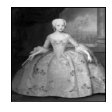

In [ ]:
plt.figure(figsize=(20,4))
ax=plt.subplot(1,n,i+1)
plt.imshow(x_test[1].reshape(256,256))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)        

Other method to **work**

In [ ]:
!cat /content/nohup.out

2022-03-07 17:00:25.985 INFO    numexpr.utils: NumExpr defaulting to 2 threads.

  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.2:8501
  External URL: http://35.193.99.51:8501



In [ ]:
!ngrok authtoken 264AXrLR0raaaManS32ao3RIkVC_3vVFsy1mfwDoL87dcKKQr

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip

--2022-03-07 17:14:13--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 18.205.222.128, 54.237.133.81, 54.161.241.46, ...
Connecting to bin.equinox.io (bin.equinox.io)|18.205.222.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.19M  40.4MB/s    in 0.3s    

2022-03-07 17:14:14 (40.4 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13832437/13832437]



In [ ]:
!unzip ngrok-stable-linux-amd64.zip

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [ ]:
get_ipython().system_raw('./ngrok http 8501 &')

In [ ]:
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    'import sys, json; print("Execute the next cell and the go to the following URL: " +json.load(sys.stdin)["tunnels"][0]["public_url"])'

Execute the next cell and the go to the following URL: https://0f10-35-193-99-51.ngrok.io


In [ ]:
!streamlit run /content/app.py

2022-03-07 17:14:39.675 INFO    numexpr.utils: NumExpr defaulting to 2 threads.

  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.2:8502
  External URL: http://35.193.99.51:8502

264AXrLR0raaaManS32ao3RIkVC_3vVFsy1mfwDoL87dcKKQr







reconstruct_painting1.png
  Stopping...
^C
